In [1]:
import meanreversion as mr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

[*********************100%***********************]  1 of 1 completed


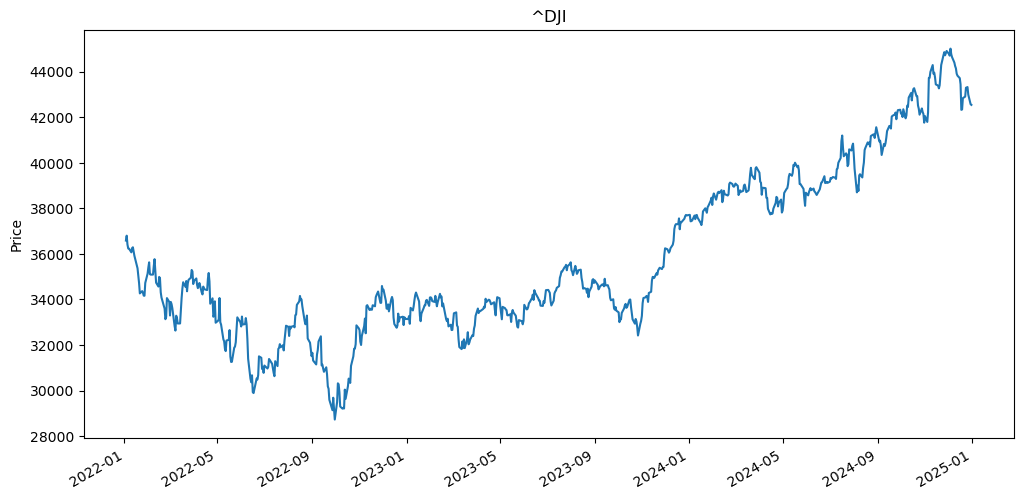

In [2]:
# Download data and plotting closing price

asset_name = "^DJI"
data = mr.download_asset(asset_name, start='2022-01-01',end='2025-01-01')
df = data.set_index("AbsTime")[["Close"]]
df = df.asfreq('B')
df = df.dropna()

df["rect"] = mr.rectifiy_price(df)   # Rectifying price using moving average
ax = df["Close"].plot(figsize=(12,6))
plt.title(asset_name)
plt.ylabel("Price")
plt.xlabel("")
plt.show()


## Rolling amplitude 

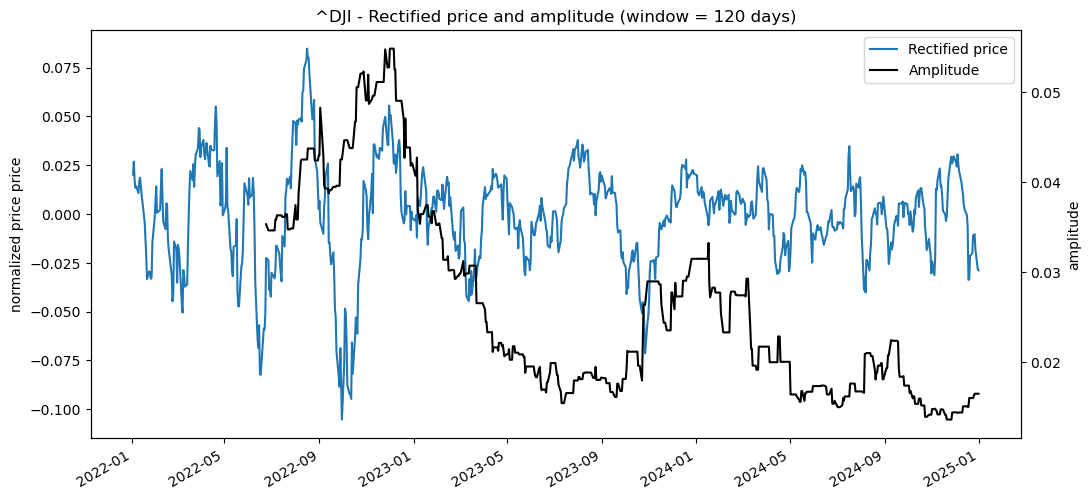

In [ ]:
window = 120

df["amplitude"] = df["rect"].rolling(window=window, center=False).apply(mr.find_amplitudes, raw=True)
#df["amplitude"] = df["rect"].rolling(window=window, center=False).std()   # alternative using standard deviation

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["amplitude"].plot(ax=ax2, color='k', label="Amplitude")
ax.set_ylabel("rect")
ax2.set_ylabel("amplitude")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
plt.title(f"{asset_name} - Rectified price and amplitude (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price price")
ax2.set_ylabel("amplitude")
plt.show()

## Rolling volatility

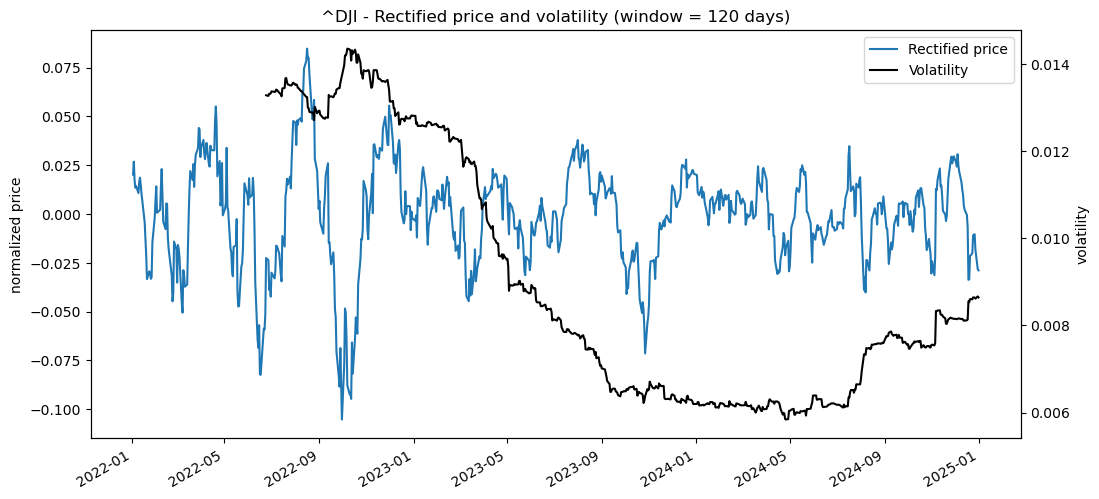

In [4]:
window = 120
df["volatility"] = df["rect"].rolling(window=window, center=False).apply(mr.volatility, raw=True)
#df["volatility"] = apply_savgol_with_nan(df["volatility"], 60, 3)

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["volatility"].plot(ax=ax2, color='k', label="Volatility")
ax.set_ylabel("rect")
ax2.set_ylabel("volatility")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
plt.title(f"{asset_name} - Rectified price and volatility (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("volatility")
plt.show()

## Rolling mean reversion index

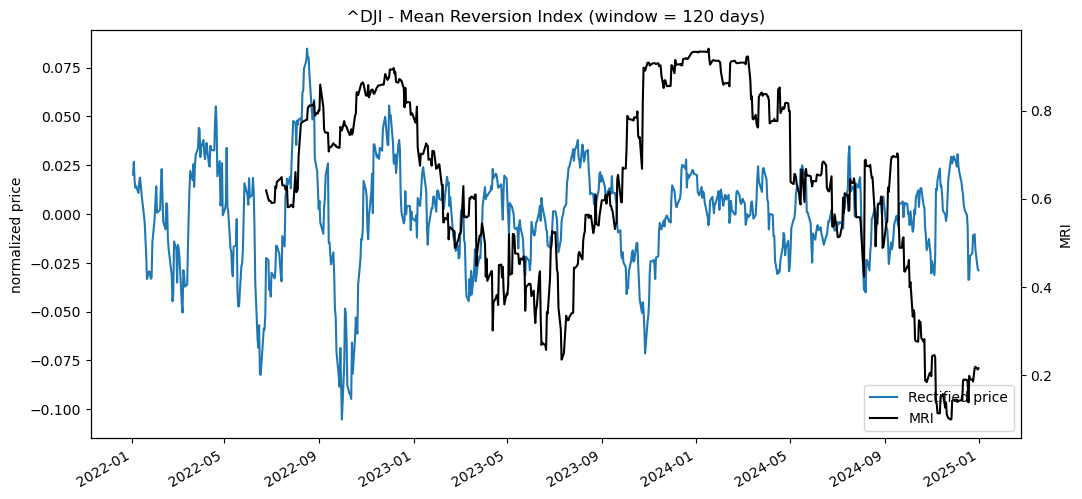

In [5]:
# normalization volatility-amplitude ratio using sigmoid function (parameter to be tuned)
#df["MRI"] = 1 / ( 1 + np.exp(150*df["volatility"]**2 / df["amplitude"]-3)) # alternative with sqared volatility (seems to work better)
df["MRI"] = df["rect"].rolling(window=window, center=False).apply(mr.mean_revertion_index, raw=True)
#df["MRI"] = apply_savgol_with_nan(df["MRI"], 90, 3) # smoothing

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("rect")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.title(f"{asset_name} - Mean Reversion Index (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("MRI")
plt.show()

## Rolling mean reversion period

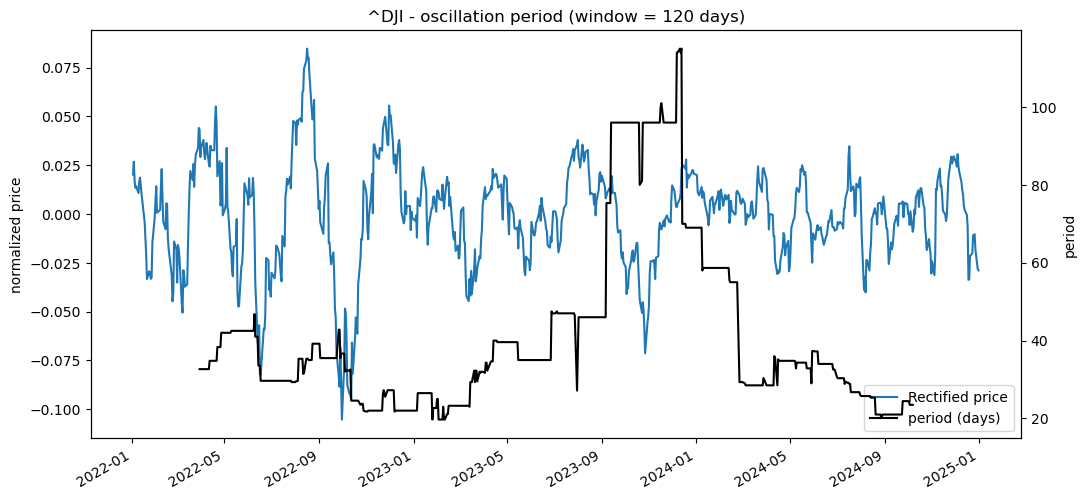

In [6]:
window = 120

df["period"] = df["rect"].rolling(window=window, center=True).apply(mr.find_period, raw=True)
#df["period"] = apply_savgol_with_nan(df["period"], 180, 3)

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["period"].plot(ax=ax2, color='k', label="period (days)")
ax.set_ylabel("rect")
ax2.set_ylabel("period")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.title(f"{asset_name} - oscillation period (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("period")
plt.show()

## Rolling version of normality test

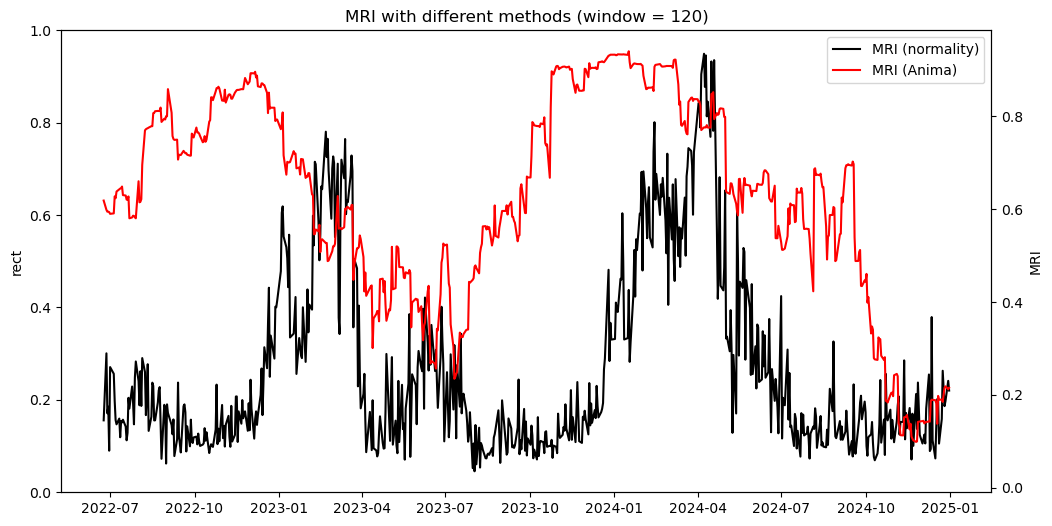

In [ ]:
from scipy.stats import norm, anderson
from math import pi
from scipy.special import erf

window = 120

df["normality"] = df["rect"].rolling(window = window, center = False).apply(mr.assess_normality_rolling, raw=True, args = (int(window/8),) ) #2400 should be ok
fig, ax = plt.subplots(figsize=(12,6))
#ax.plot(df["rect"], label = "Rectified price")
ax2 = ax.twinx()
ax2.plot(df["normality"], label = "MRI (normality)", color='k')
ax2.plot(df["MRI"], label = "MRI (Arima)", color='r')
ax.set_ylabel("rect")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
ax.set_title("MRI with different methods (window = 120)")
plt.show()

Let us repeat the same calculations with a denser dataset

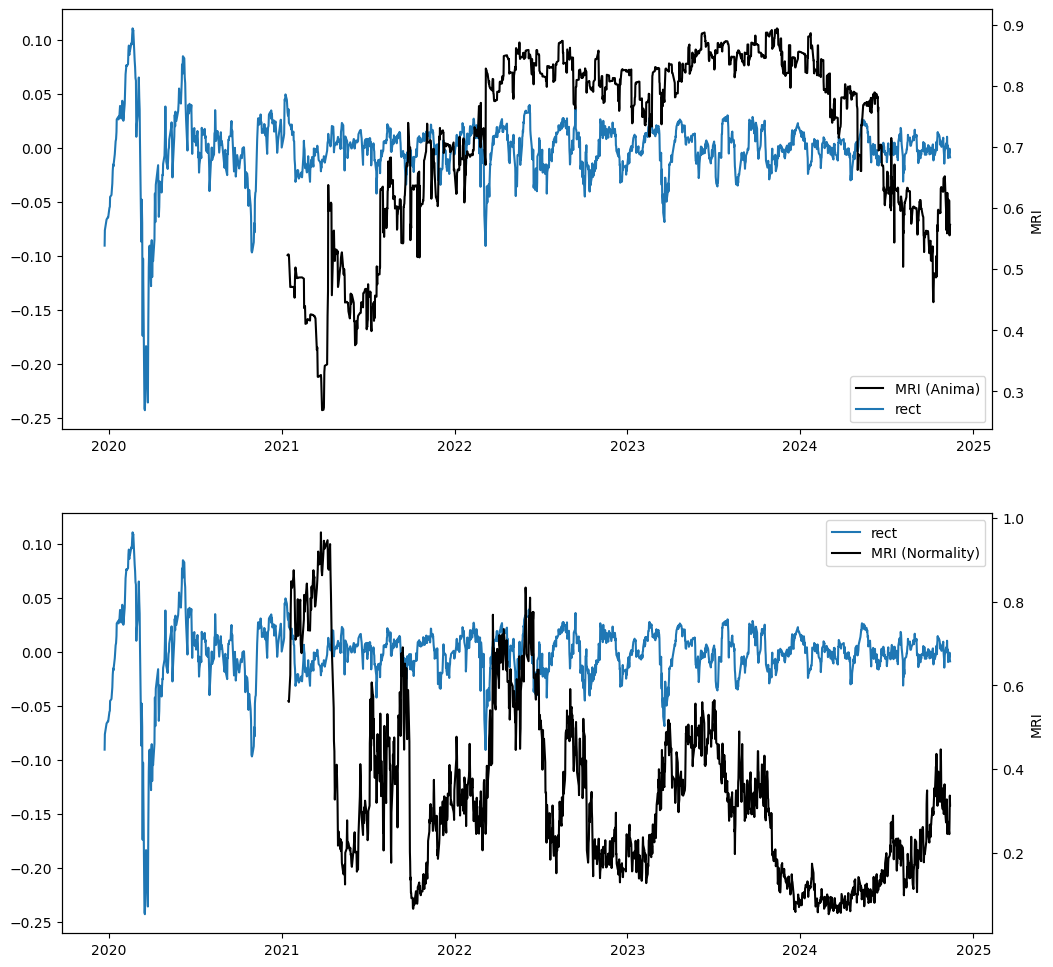

In [ ]:
DAX = mr.load_asset("data/FTSE100_M15_201912230600_202411131015.csv")
DAX = DAX.set_index("AbsTime")[["Close"]]
DAX = DAX.dropna()
DAX = DAX.iloc[::50] # shrinking the dataset for faster computation

DAX["rect"] = (DAX["Close"] - savgol_filter(DAX["Close"], 180, 3)) / DAX["Close"]   # Rectifying price using moving average
window = 300
DAX["MRI"] = DAX["rect"].rolling(window=window, center=False).apply(mr.mean_revertion_index, raw=True)
DAX["normality"] = DAX["rect"].rolling(window = window, center=False).apply(mr.assess_normality_rolling, raw=True, args = (int(window/10),) ) #2400 should be ok
DAX["normality"] = DAX["normality"].rolling(3).apply(np.mean, raw = True)
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize=(12,12))

ax12 = ax1.twinx()
ax1.plot(DAX["rect"], label = "rect")
ax12.plot(DAX["MRI"], label = "MRI (Arima)", color='k')

ax12.set_ylabel("MRI")
lines11, labels11 = ax1.get_legend_handles_labels()
lines12, labels12 = ax12.get_legend_handles_labels()
ax1.legend(lines12 + lines11, labels12 + labels11, loc = "lower right")

ax2.plot(DAX["rect"], label = "rect")
ax22 = ax2.twinx()
ax22.plot(DAX["normality"], label = "MRI (Normality)", color='k')
ax.set_ylabel("rect")
ax22.set_ylabel("MRI")
lines12, labels12 = ax2.get_legend_handles_labels()
lines22, labels22 = ax22.get_legend_handles_labels()
ax2.legend(lines12 + lines22, labels12 + labels22)
plt.show()